# 🎨 Verbalized Sampling: Creative Image Generation with Text-to-Image

## Introduction

This notebook demonstrates how **Verbalized Sampling (VS) unlocks creative diversity in image generation**. We'll compare two approaches:

- **Direct Prompting**: Traditional high-temperature sampling (often leads to similar outputs)
- **Verbalized Sampling (Ours)**: Explicitly prompts for diverse, low-probability responses from the distribution's "tails"

Our demonstration will cover:
1. **Creative Image Prompt Generation** - Generate diverse text prompts for image models
2. **Visual Comparison** - See the actual images generated from these prompts

In [ ]:
#@title Prerequisite: Put Your API Keys
import os
from openai import OpenAI
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO
from IPython.display import display, HTML, Markdown, clear_output
import base64
import re
import textwrap

# Put Your API Keys (or use environment variables)
os.environ["OPENAI_API_KEY"] = ''
os.environ["GOOGLE_API_KEY"] = ''  # Add your Google key for image generation

# Initialize clients
openai_client = OpenAI()
google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY", ""))

In [31]:
#@title Utility Functions
def display_images_row(images_data, labels, title):
    """Display images in a single row with labels"""
    display(Markdown(f"### {title}"))
    
    html = "<table style='border-collapse: collapse;'><tr>"
    for img_data, label in zip(images_data, labels):
        html += f"<td style='text-align:center; padding:10px;'>"
        html += f"<img src='data:image/png;base64,{img_data}' style='max-width:200px; max-height:200px;'/><br>"
        html += f"<small><b>{label}</b></small></td>"
    html += "</tr></table>"
    display(HTML(html))

def display_prompt_comparison(direct_prompts, vs_prompts, title):
    """Display prompts in a side-by-side comparison table"""
    display(Markdown(f"### {title}"))
    
    html = "<table border='1' style='width:100%; border-collapse: collapse;'>"
    html += "<tr><th style='width:50%; padding:10px; background-color:#f0f0f0;'>Direct Prompting</th>"
    html += "<th style='width:50%; padding:10px; background-color:#e8f4f8;'>Verbalized Sampling (Ours)</th></tr>"
    
    max_prompts = max(len(direct_prompts), len(vs_prompts))
    for i in range(max_prompts):
        html += "<tr>"
        
        # Direct prompting column
        html += "<td style='vertical-align:top; padding:10px;'>"
        if i < len(direct_prompts):
            html += f"<strong>Prompt {i+1}:</strong><br>"
            html += f"<div style='font-family: monospace; font-size: 0.85em; line-height: 1.4;'>{direct_prompts[i][:300]}...</div>"
        html += "</td>"
        
        # Verbalized sampling column
        html += "<td style='vertical-align:top; padding:10px;'>"
        if i < len(vs_prompts):
            html += f"<strong>Prompt {i+1}:</strong><br>"
            html += f"<div style='font-family: monospace; font-size: 0.85em; line-height: 1.4;'>{vs_prompts[i][:300]}...</div>"
        html += "</td>"
        
        html += "</tr>"
    
    html += "</table>"
    display(HTML(html))

def generate_and_save_image(prompt, save_path, client):
    """Generate image from prompt using Gemini and return base64 encoded thumbnail"""
    response = client.models.generate_content(
        model="gemini-2.0-flash-exp-image",
        contents=[prompt.strip()],
    )
    
    for part in response.candidates[0].content.parts:
        if part.inline_data is not None:
            # Save high-res image
            image = Image.open(BytesIO(part.inline_data.data))
            image.save(save_path)
            
            # Create thumbnail for display
            image.thumbnail((200, 200))
            buffered = BytesIO()
            image.save(buffered, format="PNG")
            return base64.b64encode(buffered.getvalue()).decode()
    
    return None

def generate_and_save_image_gpt(prompt, save_path, client):
    """Generate image from prompt using GPT and return base64 encoded thumbnail"""
    response = client.responses.create(
        model="gpt-4.1",
        input=prompt.strip(),
        tools=[{"type": "image_generation"}],
    )
    
    # Extract image data
    image_data = [
        output.result
        for output in response.output
        if output.type == "image_generation_call"
    ]
    
    if image_data:
        image_base64 = image_data[0]
        image_bytes = base64.b64decode(image_base64)
        
        # Save high-res image
        with open(save_path, "wb") as f:
            f.write(image_bytes)
        
        # Create thumbnail for display
        image = Image.open(BytesIO(image_bytes))
        image.thumbnail((200, 200))
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode()
    
    return None

---

## Task: Text-to-Image Prompt Generation

We'll demonstrate the difference between Direct Prompting and Verbalized Sampling by generating diverse image prompts.

**Scenario**: Generate creative image prompts for: *"An astronaut riding a unicorn"*

---

## Task: Text-to-Image Prompt Generation

We'll demonstrate the difference between Direct Prompting and Verbalized Sampling by generating diverse image prompts.

**Scenario**: Generate creative image prompts for: *"An astronaut riding a unicorn"*

In [5]:
IMAGE_CONCEPT = "An astronaut riding a unicorn"

direct_prompts = []
for i in range(5):
    response = openai_client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {
                "role": "user",
                "content": f"Write a detailed one-paragraph image generation prompt for: {IMAGE_CONCEPT}"
            }
        ],
        temperature=1.0
    )
    direct_prompts.append(response.choices[0].message.content)
    print(f"Generated prompt {i+1}/5")

clear_output()
print("✅ Generated 5 prompts with Direct Prompting")
print(f"\n📝 Sample prompt:\n{textwrap.fill(direct_prompts[0][:200], width=80)}...")

✅ Generated 5 prompts with Direct Prompting

📝 Sample prompt:
A majestic astronaut in a sleek, white and silver spacesuit, complete with a
reflective visor and intricate mission patches, is riding atop a radiant,
ethereal unicorn. The unicorn’s coat gleams with...


## Method 2: Verbalized Sampling (Ours)

Our approach: Explicitly prompt the model to generate diverse, low-probability responses from the distribution's "tails".

In [6]:
response = openai_client.chat.completions.create(
    model="gpt-4.1",
    messages=[
        {
            "role": "system",
            "content": """You are a helpful assistant. For each query, please generate a set of 5 possible responses, \
each within a separate <response> tag. Responses should each include a <text> and a numeric <probability>. \
Please sample at random from the tails of the distribution, such that the probability of each response is less than 0.10."""
        },
        {
            "role": "user",
            "content": f"Write a detailed one-paragraph image generation prompt for: {IMAGE_CONCEPT}"
        }
    ],
    temperature=1.0
)

# Extract text from <text> tags
vs_prompts = re.findall(r'<text>(.*?)</text>', response.choices[0].message.content, re.DOTALL)

print("✅ Generated 5 diverse prompts with Verbalized Sampling")
print(f"\n📝 Sample prompt:\n{textwrap.fill(vs_prompts[0][:200], width=80)}...")

✅ Generated 5 diverse prompts with Verbalized Sampling

📝 Sample prompt:
An astronaut in a sleek white spacesuit, complete with reflective visor, is
riding majestically atop a luminous, ethereal unicorn with a flowing silver
mane. They are soaring above the cratered surfac...


### 📊 Prompt Comparison

Let's compare the generated prompts side-by-side:

In [7]:
display_prompt_comparison(direct_prompts, vs_prompts, "Image Prompt Generation Comparison")

### Image Prompt Generation Comparison

Direct Prompting,Verbalized Sampling (Ours)
"Prompt 1:A majestic astronaut in a sleek, white and silver spacesuit, complete with a reflective visor and intricate mission patches, is riding atop a radiant, ethereal unicorn. The unicorn’s coat gleams with iridescent hues of pale blue and lavender, its long, spiraling horn glowing with cosmic energy. The ...","Prompt 1:An astronaut in a sleek white spacesuit, complete with reflective visor, is riding majestically atop a luminous, ethereal unicorn with a flowing silver mane. They are soaring above the cratered surface of the moon, the star-studded expanse of deep space stretching out behind them. The unicorn's horn..."
"Prompt 2:A highly detailed digital illustration of an astronaut in a sleek, futuristic white and silver spacesuit, complete with a reflective helmet, riding atop a majestic unicorn. The unicorn features a flowing, iridescent mane and tail, a spiraling golden horn, and powerful, muscular legs as it gallops gr...","Prompt 2:Imagine a whimsical scene on a distant planet, where an astronaut wearing a traditional NASA suit is gently perched on a pearly white unicorn with shimmering golden hooves. The unicorn gallops across a surreal, rocky extraterrestrial landscape under an enormous violet sky filled with swirling nebula..."
"Prompt 3:A hyper-realistic digital illustration of an astronaut riding a majestic unicorn through the vast expanse of outer space. The astronaut's suit is detailed with reflective visors, textured fabric, and intricate NASA patches, while the unicorn has a shimmering, iridescent mane and glowing horn. Distan...","Prompt 3:Create a vibrant image featuring an astronaut in a futuristic space suit riding a majestic unicorn across a galaxy filled with sparkling stars and swirling gaseous clouds. The unicorn’s coat glistens with iridescent colors, and its long, spiraled horn emits a soft, celestial light. The background sh..."
"Prompt 4:Imagine a vibrant, highly detailed digital illustration depicting an astronaut in a shining white spacesuit, complete with a reflective helmet visor, riding atop a majestic unicorn. The unicorn has a shimmering, iridescent mane and tail, and its horn glows with a magical light. The scene is set agai...","Prompt 4:Visualize an astronaut clad in advanced, silver-finished space armor astride a dazzling, pure white unicorn galloping over the rings of Saturn. The unicorn's horn glows sapphire blue, leaving a glittering trail in the vacuum of space. Behind them, Saturn’s immense bands and bright stars provide a su..."
"Prompt 5:A stunning, highly detailed illustration of an astronaut in a sleek, reflective white space suit, complete with a glowing helmet visor, confidently riding atop a majestic unicorn. The unicorn has a flowing, iridescent mane and tail, with a luminous, spiraling horn emitting a soft magical glow. The s...","Prompt 5:Envision a detailed scene where an astronaut, visored helmet reflecting pinpoints of distant stars, rides atop a magnificent unicorn. The unicorn’s mane and tail ripple in zero gravity, strands sparkling with stardust as they traverse a surreal, otherworldly landscape hovering above the atmosphere o..."


**Takeaway**: Notice how Direct Prompting produces prompts with similar themes and descriptions (cosmic nebula, pristine suits, etc.), while Verbalized Sampling explores more diverse styles (watercolor, synthwave, Baroque, miniature photography, etc.).

In [22]:
### Generating Images with Direct Prompting

print("🎨 Generating images from Direct Prompting...")
os.makedirs("direct", exist_ok=True)

direct_images = []
for i, prompt in enumerate(direct_prompts):
    print(f"  Generating image {i+1}/5...")
    img_data = generate_and_save_image(
        prompt, 
        f"direct/image_{i+1}.png", 
        google_client
    )
    if img_data:
        direct_images.append(img_data)

clear_output()
print(f"✅ Generated {len(direct_images)} images with Direct Prompting")

✅ Generated 5 images with Direct Prompting


In [23]:
### Generating Images with Verbalized Sampling

print("🎨 Generating images from Verbalized Sampling...")
os.makedirs("vs", exist_ok=True)

vs_images = []
for i, prompt in enumerate(vs_prompts):
    print(f"  Generating image {i+1}/5...")
    img_data = generate_and_save_image(
        prompt, 
        f"vs/image_{i+1}.png", 
        google_client
    )
    if img_data:
        vs_images.append(img_data)

clear_output()
print(f"✅ Generated {len(vs_images)} images with Verbalized Sampling")

✅ Generated 5 images with Verbalized Sampling


---

## Alternative: Using GPT Image Generation

Let's also try generating images using OpenAI's GPT image generation API to compare with Gemini's results.

### Generating Images with GPT (Direct Prompting)

In [38]:
print("🎨 Generating images with GPT (Direct Prompting)...")
os.makedirs("direct_gpt", exist_ok=True)

direct_gpt_images = []
for i, prompt in enumerate(direct_prompts):
    print(f"  Generating GPT image {i+1}/5...")
    try:
        img_data = generate_and_save_image_gpt(
            prompt, 
            f"direct_gpt/image_{i+1}.png", 
            openai_client
        )
        if img_data:
            direct_gpt_images.append(img_data)
    except Exception as e:
        print(f"  Warning: Failed to generate image {i+1}: {e}")

# clear_output()
print(f"✅ Generated {len(direct_gpt_images)} images with GPT (Direct Prompting)")

🎨 Generating images with GPT (Direct Prompting)...
  Generating GPT image 1/5...
  Generating GPT image 2/5...
  Generating GPT image 3/5...
  Generating GPT image 4/5...
  Generating GPT image 5/5...
✅ Generated 0 images with GPT (Direct Prompting)


In [ ]:
### Generating Images with Verbalized Sampling

print("🎨 Generating images from Verbalized Sampling...")
os.makedirs("vs_gpt", exist_ok=True)

vs_gpt_images = []
for i, prompt in enumerate(vs_prompts):
    print(f"  Generating image {i+1}/5...")
    img_data = generate_and_save_image(
        prompt, 
        f"vs_gpt/image_{i+1}.png", 
        openai_client
    )
    if img_data:
        vs_gpt_images.append(img_data)

clear_output()
print(f"✅ Generated {len(vs_images)} images with Verbalized Sampling")

✅ Generated 5 images with Verbalized Sampling


---

## Visual Comparison: Gemini vs GPT

Let's compare the image generation quality between Gemini and GPT for both Direct Prompting and Verbalized Sampling.

### 🖼️ Gemini: Direct Prompting Results

### Direct Prompting - Generated Images

Direct Prompting 1,Direct Prompting 2,Direct Prompting 3,Direct Prompting 4,Direct Prompting 5

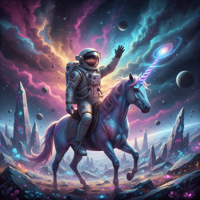
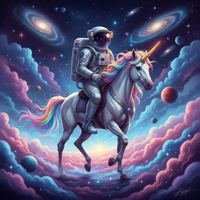
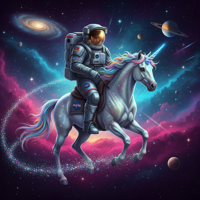
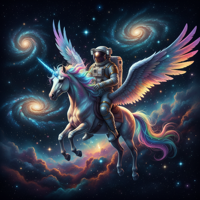
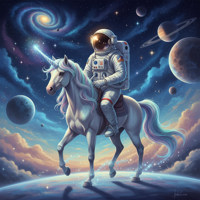

In [36]:
display_images_row(
    direct_images, 
    [f"Direct Prompting {i+1}" for i in range(len(direct_images))],
    "Direct Prompting - Generated Images"
)

### Verbalized Sampling - Generated Images

Verbalized Sampling 1,Verbalized Sampling 2,Verbalized Sampling 3,Verbalized Sampling 4,Verbalized Sampling 5

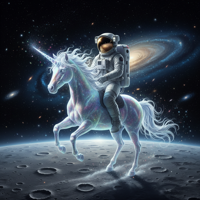
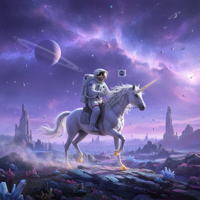
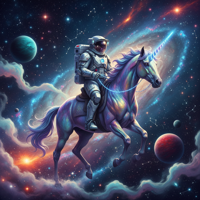
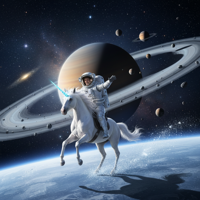
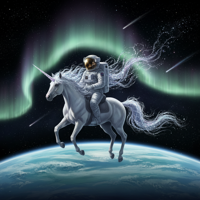

In [37]:
display_images_row(
    vs_images, 
    [f"Verbalized Sampling {i+1}" for i in range(len(vs_images))],
    "Verbalized Sampling - Generated Images"
)

### 🎯 Key Observation: Visual Diversity

**What to Notice:**

🔍 **Direct Prompting Images** tend to share common characteristics:
- Similar color palettes (often blues, purples, cosmic themes)
- Consistent artistic style (photorealistic/cinematic)
- Repetitive compositional elements (astronaut centered, unicorn in similar poses)
- Converging on the "mode" of the distribution (highest probability interpretations)

✨ **Verbalized Sampling Images** show significantly more variety:
- Diverse artistic styles (watercolor, synthwave, Baroque painting, miniature photography, etc.)
- Different color schemes and moods (warm vs cool, vibrant vs muted)
- Creative compositional choices (unusual angles, varied settings)
- Exploring the "tails" of the distribution (low probability but high creativity interpretations)

**The Result:** With VS, a single API call gives you a **creative portfolio** instead of **variations on a theme**. Perfect for brainstorming, creative exploration, and finding unique concepts!

---

# Summary & Key Takeaways

## What We've Demonstrated

✅ **Image Prompt Generation**: Verbalized Sampling produces more diverse and creative prompts compared to Direct Prompting

✅ **Visual Diversity**: The resulting images show significantly more variety in style, composition, and artistic interpretation

✅ **Same Computational Cost**: No additional overhead - single API call generates multiple diverse options

## Key Benefits of Verbalized Sampling

📣 **Training-Free**: Simple prompt modification, no model retraining required

🎯 **Tunable Diversity**: Control creativity by adjusting the probability threshold (e.g., < 0.10, < 0.05)

📈 **Scales with Model Size**: Works even better on larger, more capable models

✨ **Practical Applications**: 
- Creative content generation (art, stories, marketing)
- Brainstorming and ideation
- Text-to-image prompt engineering
- Design exploration and prototyping

## 💡 Practical Tips for Using VS

- **Use capable models**: Works best with GPT-4, Claude 3.5, Gemini 2.0 Pro
- **Adjust probability threshold**: Lower thresholds (0.05, 0.01) = more creativity
- **Use JSON schema for reliability**: Ensures consistent parsing of structured outputs
- **Experiment with temperature**: Combine VS with high temperature (0.9-1.0) for maximum diversity

---

# 🔗 Useful Links

- [ArXiv Paper](https://arxiv.org/abs/2510.01171)
- [GitHub Repository](https://github.com/CHATS-lab/verbalize-sampling)
- [PyPI Package](https://pypi.org/project/verbalized-sampling/)